In [1]:
import numpy as np
import pandas as pd

import sklearn.metrics
import sklearn.preprocessing

import matplotlib.pyplot as plt

import torch
from torch import nn

In [2]:
time_series = pd.read_csv('time_series.csv').astype('float32')
time_series.head()

,Year,Month,NumCases
0,1980.0,1.0,1825.0
1,1980.0,2.0,1730.0
2,1980.0,3.0,1743.0
3,1980.0,4.0,1760.0
4,1980.0,5.0,1863.0


In [3]:
for i in range(1, 13, 1):
    time_series[f'NumCases_{i}'] = time_series['NumCases'].shift(i)

In [4]:
time_series = time_series[12:]
time_series.head()

,Year,Month,NumCases,NumCases_1,NumCases_2,NumCases_3,NumCases_4,NumCases_5,NumCases_6,NumCases_7,NumCases_8,NumCases_9,NumCases_10,NumCases_11,NumCases_12
12,1981.0,1.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,1743.0,1730.0,1825.0
13,1981.0,2.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,1743.0,1730.0
14,1981.0,3.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,1743.0
15,1981.0,4.0,1771.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0
16,1981.0,5.0,1860.0,1771.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0


In [5]:
test = time_series[-60:]
train = time_series[:-60]
val = train[-60:]
train = train[:-60]

train.shape, val.shape, test.shape

((288, 15), (60, 15), (60, 15))

In [6]:
def features_target(data_frame):
    return data_frame[data_frame.columns[3:]].to_numpy(), data_frame['NumCases'].to_numpy()

In [7]:
X_train, Y_train = features_target(train)
X_val, Y_val = features_target(val)
X_test, Y_test = features_target(test)

In [8]:
scaler_x = sklearn.preprocessing.StandardScaler()
scaler_y = sklearn.preprocessing.StandardScaler()

X_train = scaler_x.fit_transform(X_train)[..., None]
Y_train = scaler_y.fit_transform(Y_train.reshape(-1, 1))

X_val = scaler_x.transform(X_val)[..., None]
Y_val = scaler_y.transform(Y_val.reshape(-1, 1))

X_test = scaler_x.transform(X_test)[..., None]

In [9]:
class RNN(nn.Module):
    def __init__(self, hidden_size=32, many_to_one=False):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )
        self.out = nn.Linear(hidden_size, 1)
        self.many_to_one = many_to_one

    def forward(self, x, h_state=None):
        rnn_out, h_state = self.rnn(x, h_state)
        linear_out = self.out(rnn_out[:, -1, :]) if self.many_to_one else self.out(rnn_out)
        return linear_out, h_state

In [10]:
torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn = RNN(many_to_one=True).to(device)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.0001)
loss_func = nn.MSELoss()
h_state = None

In [11]:
def batch_generator(X, Y, batch_size=24):
    for i in range(0, X.shape[0], batch_size):
        yield X[i:i+batch_size], Y[i:i+batch_size]

In [12]:
best_loss = np.inf
best_epoch = -1
STATE_DICT_PATH = 'best_model.pth'

In [13]:
for epoch in range(3000):
    rnn.train()
    train_losses = []
    for batch_x, batch_y in batch_generator(X_train, Y_train):
        batch_x = torch.from_numpy(batch_x).to(device)
        batch_y = torch.from_numpy(batch_y).to(device)
        prediction, h_state = rnn(batch_x, h_state)
        h_state = h_state.data

        loss = loss_func(prediction, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append((loss * batch_x.size(0)).detach().numpy())
    
    rnn.eval()
    with torch.no_grad():
        prediction, _ = rnn(torch.from_numpy(X_val).to(device))
        val_loss = loss_func(prediction, torch.from_numpy(Y_val).to(device)).numpy()

    print(f'Epoch:{epoch}', 'train_loss:', np.sqrt(np.mean(train_losses)), 'val_loss:', np.sqrt(val_loss))

    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch
        torch.save(rnn.state_dict(), STATE_DICT_PATH)

Epoch:0 train_loss: 4.903879 val_loss: 0.9642679
Epoch:1 train_loss: 4.8542786 val_loss: 0.95411956
Epoch:2 train_loss: 4.808771 val_loss: 0.9434365
Epoch:3 train_loss: 4.763676 val_loss: 0.9326645
Epoch:4 train_loss: 4.718588 val_loss: 0.92185795
Epoch:5 train_loss: 4.6732507 val_loss: 0.91098726
Epoch:6 train_loss: 4.6274433 val_loss: 0.9000025
Epoch:7 train_loss: 4.580955 val_loss: 0.8888491
Epoch:8 train_loss: 4.5335746 val_loss: 0.87747157
Epoch:9 train_loss: 4.4850774 val_loss: 0.8658108
Epoch:10 train_loss: 4.4352183 val_loss: 0.8538026
Epoch:11 train_loss: 4.383724 val_loss: 0.841375
Epoch:12 train_loss: 4.330296 val_loss: 0.8284483
Epoch:13 train_loss: 4.2746105 val_loss: 0.8149344
Epoch:14 train_loss: 4.216322 val_loss: 0.8007359
Epoch:15 train_loss: 4.1550612 val_loss: 0.7857451
Epoch:16 train_loss: 4.0904365 val_loss: 0.769842
Epoch:17 train_loss: 4.022037 val_loss: 0.7528944
Epoch:18 train_loss: 3.9494448 val_loss: 0.7347614
Epoch:19 train_loss: 3.8722718 val_loss: 0.71530

In [14]:
print('best loss on validation:', np.sqrt(best_loss), 'Epoch:', best_epoch)

best loss on validation: 0.3730782 Epoch: 1938


In [15]:
best_model = RNN(many_to_one=True).to(device)
best_model.load_state_dict(torch.load(STATE_DICT_PATH))
best_model.eval()

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [16]:
with torch.no_grad():
    Y_predict_scaled = best_model(torch.from_numpy(X_test).to(device))[0].numpy()

Y_predict = scaler_y.inverse_transform(Y_predict_scaled).squeeze()

In [17]:
print('RMSE:', sklearn.metrics.mean_squared_error(Y_test, Y_predict, squared=False))

RMSE: 65.57076


In [19]:
prediction = [np.nan] * time_series.shape[0]
prediction[-60:] = Y_predict
time_series['NumCases_predict'] = prediction

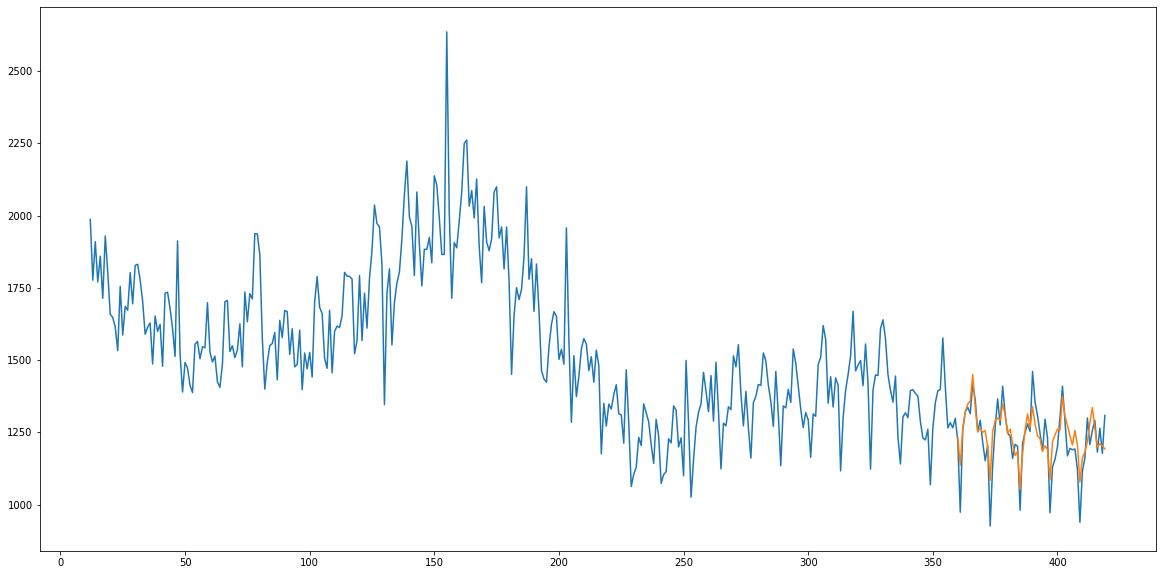

In [20]:
plt.figure(figsize=(20,10)) 
plt.plot(time_series['NumCases'])
plt.plot(time_series['NumCases_predict'][-60:])
plt.show()